<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/Cnn%2Bknnbalance_DaTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:

# Define the path to your image directories for healthy and ill samples
normal_path = "/content/drive/MyDrive/Ankle_balance/normal"
ill_path = "/content/drive/MyDrive/Ankle_balance/ill"

# Create lists to store image data and labels
dataset_images = []
dataset_labels = []
# Reading images from the normal directory
for files in os.listdir(normal_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(normal_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(0)  # Label for healthy images

# Reading images from the ill directory
for files in os.listdir(ill_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(ill_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(1)  # Label for ill images
# Create dictionaries to store results
parameters = {}
accuracies = {}
variances = {}
confusion_matrices = {}
classification_reports = {}

print(len(dataset_images))

144


In [38]:
# Convert the lists to NumPy arrays
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)

# Normalize pixel values to the range [0, 1]
dataset_images = dataset_images / 255.0

seed = 42  # You can use any integer value as the seed

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_images, dataset_labels, test_size=0.2, random_state=seed)
# Calculate the number of images in the training set
num_train_images = len(X_train)
print("Number of images in the training set:", num_train_images)

# Calculate the number of images in the testing set
num_test_images = len(X_test)
print("Number of images in the testing set:", num_test_images)


Number of images in the training set: 115
Number of images in the testing set: 29


In [39]:
# Create a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model on the training dataset
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the CNN model for both training and testing datasets
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Define a range of k values and other hyperparameters for k-NN
k_values = [3, 5, 7, 9]
param_grid = {'n_neighbors': k_values, 'weights': ['uniform', 'distance']}

# Use GridSearchCV to find the best k-NN parameters
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_features, y_train)

best_k = grid_search.best_params_['n_neighbors']
best_weight = grid_search.best_params_['weights']

Epoch 1/10
4/4 [==============================] - 16s 4s/step - loss: 0.8798 - accuracy: 0.4783 - val_loss: 0.7044 - val_accuracy: 0.5517
Epoch 2/10
4/4 [==============================] - 14s 4s/step - loss: 0.8113 - accuracy: 0.5913 - val_loss: 0.7872 - val_accuracy: 0.4138
Epoch 3/10
4/4 [==============================] - 13s 3s/step - loss: 0.7375 - accuracy: 0.5565 - val_loss: 0.7170 - val_accuracy: 0.4828
Epoch 4/10
4/4 [==============================] - 13s 3s/step - loss: 0.6819 - accuracy: 0.5130 - val_loss: 0.6947 - val_accuracy: 0.5172
Epoch 5/10
4/4 [==============================] - 13s 3s/step - loss: 0.6332 - accuracy: 0.6783 - val_loss: 0.7119 - val_accuracy: 0.4138
Epoch 6/10
4/4 [==============================] - 13s 3s/step - loss: 0.6253 - accuracy: 0.6435 - val_loss: 0.6831 - val_accuracy: 0.6897
Epoch 7/10
4/4 [==============================] - 13s 3s/step - loss: 0.5717 - accuracy: 0.7391 - val_loss: 0.6914 - val_accuracy: 0.4828
Epoch 8/10
4/4 [==================

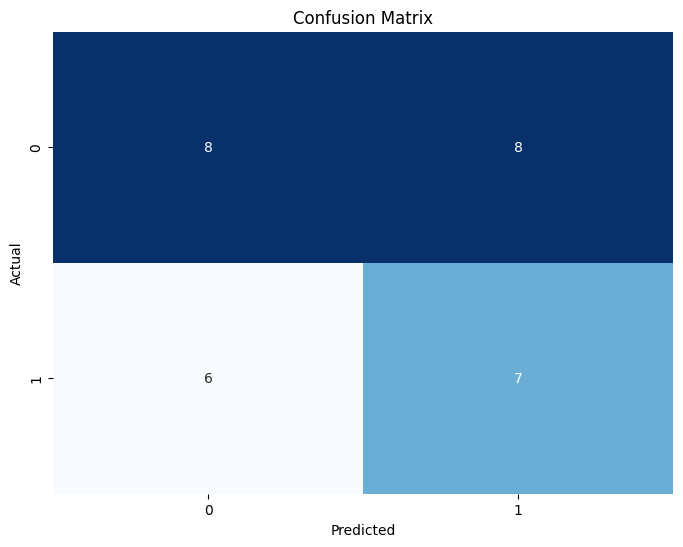

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.50      0.53        16
           1       0.47      0.54      0.50        13

    accuracy                           0.52        29
   macro avg       0.52      0.52      0.52        29
weighted avg       0.52      0.52      0.52        29

Best k-NN parameters: k=9, weights=uniform
k-NN accuracy: 0.5172413793103449


In [43]:
# Train the k-NN model with the best parameters
knn = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight)
knn.fit(X_train_features, y_train)
y_pred = knn.predict(X_test_features)

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the classification report
cr = classification_report(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(cr)

# Evaluate the k-NN model
accuracy = accuracy_score(y_test, y_pred)
print(f'Best k-NN parameters: k={best_k}, weights={best_weight}')
print(f'k-NN accuracy: {accuracy}')

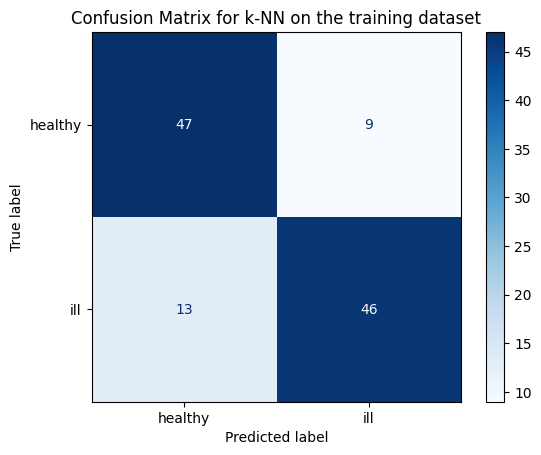

Classification Report for k-NN on the training dataset:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81        56
           1       0.84      0.78      0.81        59

    accuracy                           0.81       115
   macro avg       0.81      0.81      0.81       115
weighted avg       0.81      0.81      0.81       115

k-NN training accuracy: 0.808695652173913


In [44]:
# Train the k-NN model with the best parameters on the training dataset
knn = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight)
knn.fit(X_train_features, y_train)

# Predict on the training dataset
y_train_pred = knn.predict(X_train_features)

# Calculate the confusion matrix for the training dataset
train_cm = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix for the training dataset
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "ill"])  # Replace with your class labels
train_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for k-NN on the training dataset")
plt.show()

# Print the classification report for the training dataset
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for k-NN on the training dataset:\n", train_report)

# Calculate and display the classification accuracy on the training dataset
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'k-NN training accuracy: {train_accuracy}')


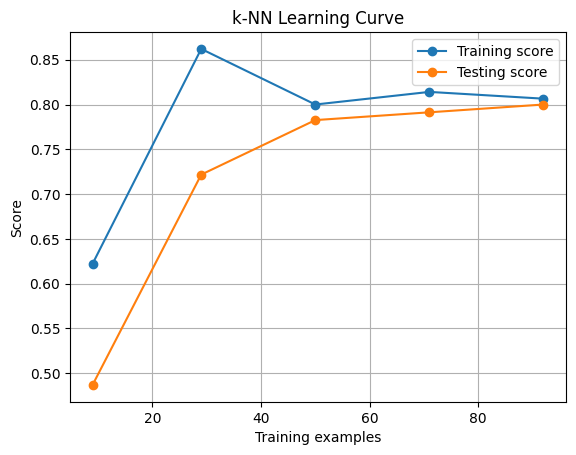

In [45]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Create a k-NN classifier with the best parameters from grid search
knn_classifier = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight)

# Compute the learning curve data for k-NN
train_sizes, train_scores, test_scores = learning_curve(
    knn_classifier, X_train_features, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve for k-NN
plt.figure()
plt.title("k-NN Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Testing score")

plt.legend(loc="best")
plt.show()
